# Forecasting with a stateful RNN

## Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

keras = tf.keras

2023-02-25 11:03:23.328504: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)
    
def trend(time, slope=0):
    return slope * time


def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

  
def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)
  
  
def white_noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

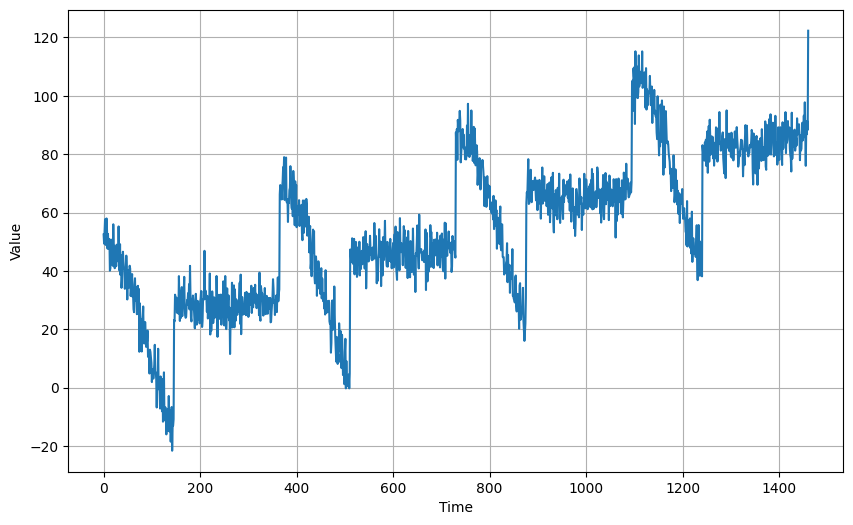

In [3]:
time = np.arange(4 * 365 + 1)

slope = 0.05
baseline = 10
amplitude = 40
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

noise_level = 5
noise = white_noise(time, noise_level, seed=42)

series += noise

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

In [4]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

## Stateful RNN Forecasting

In [5]:
def sequential_window_dataset(series, window_size):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=window_size, drop_remainder=True)
    ds = ds.flat_map(lambda window: window.batch(window_size + 1))
    ds = ds.map(lambda window: (window[:-1], window[1:]))
    return ds.batch(1).prefetch(1)

In [6]:
class ResetStatesCallback(keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs):
        self.model.reset_states()

## The empirical model without mechanism

In [7]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = sequential_window_dataset(x_train, window_size)

model = keras.models.Sequential([
  keras.layers.SimpleRNN(100, return_sequences=True, stateful=True,
                         batch_input_shape=[1, None, 1]),
  keras.layers.SimpleRNN(100, return_sequences=True, stateful=True),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200.0)
])
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 30))
reset_states = ResetStatesCallback()
optimizer = keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100,
                    callbacks=[lr_schedule, reset_states])

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


2023-02-25 11:03:27.629993: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/100
33/33 [==============================] - 2s 18ms/step - loss: 41.1785 - mae: 41.6756 - lr: 1.0000e-08
Epoch 2/100
33/33 [==============================] - 0s 11ms/step - loss: 21.9697 - mae: 22.4650 - lr: 1.0798e-08
Epoch 3/100
33/33 [==============================] - 0s 6ms/step - loss: 17.7508 - mae: 18.2400 - lr: 1.1659e-08
Epoch 4/100
33/33 [==============================] - 0s 6ms/step - loss: 15.5184 - mae: 16.0060 - lr: 1.2589e-08
Epoch 5/100
33/33 [==============================] - 0s 5ms/step - loss: 13.5368 - mae: 14.0171 - lr: 1.3594e-08
Epoch 6/100
33/33 [==============================] - 0s 6ms/step - loss: 12.2575 - mae: 12.7444 - lr: 1.4678e-08
Epoch 7/100
33/33 [==============================] - 0s 6ms/step - loss: 11.8158 - mae: 12.3004 - lr: 1.5849e-08
Epoch 8/100
33/33 [==============================] - 0s 6ms/step - loss: 11.7067 - mae: 12.1951 - lr: 1.7113e-08
Epoch 9/100
33/33 [==============================] - 0s 7ms/step - loss: 11.6348 - mae: 12.122

(1e-08, 0.0001, 0.0, 30.0)

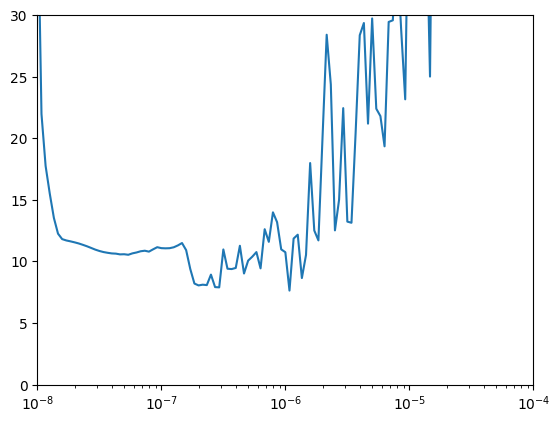

In [8]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

In [9]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = sequential_window_dataset(x_train, window_size)
valid_set = sequential_window_dataset(x_valid, window_size)

model = keras.models.Sequential([
  keras.layers.SimpleRNN(100, return_sequences=True, stateful=True,
                         batch_input_shape=[1, None, 1]),
  keras.layers.SimpleRNN(100, return_sequences=True, stateful=True),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200.0)
])
optimizer = keras.optimizers.SGD(lr=1e-7, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
reset_states = ResetStatesCallback()
model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint.h5", save_best_only=True)
early_stopping = keras.callbacks.EarlyStopping(patience=50)
model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping, model_checkpoint, reset_states])

Epoch 1/500
33/33 [==============================] - 2s 18ms/step - loss: 35200.8672 - mae: 35201.3672 - val_loss: 67234.1562 - val_mae: 67234.6484
Epoch 2/500
33/33 [==============================] - 0s 11ms/step - loss: 49476.2695 - mae: 49476.7617 - val_loss: 18926.9727 - val_mae: 18927.4727
Epoch 3/500
33/33 [==============================] - 0s 9ms/step - loss: 40465.7188 - mae: 40466.2227 - val_loss: 96780.5156 - val_mae: 96781.0234
Epoch 4/500
33/33 [==============================] - 0s 8ms/step - loss: 62988.6250 - mae: 62989.1289 - val_loss: 13414.0479 - val_mae: 13414.5479
Epoch 5/500
33/33 [==============================] - 0s 8ms/step - loss: 51556.7969 - mae: 51557.3047 - val_loss: 80886.3984 - val_mae: 80886.8984
Epoch 6/500
33/33 [==============================] - 0s 8ms/step - loss: 101121.1875 - mae: 101121.6797 - val_loss: 80019.1328 - val_mae: 80019.6328
Epoch 7/500
33/33 [==============================] - 0s 8ms/step - loss: 38355.2773 - mae: 38355.7812 - val_loss: 

In [10]:
model = keras.models.load_model("my_checkpoint.h5")

In [11]:
model.reset_states()
empirical_rnn_forecast = model.predict(series[np.newaxis, :, np.newaxis])
empirical_rnn_forecast = empirical_rnn_forecast[0, split_time - 1:-1, 0]

1/1 [==============================] - 0s 298ms/step


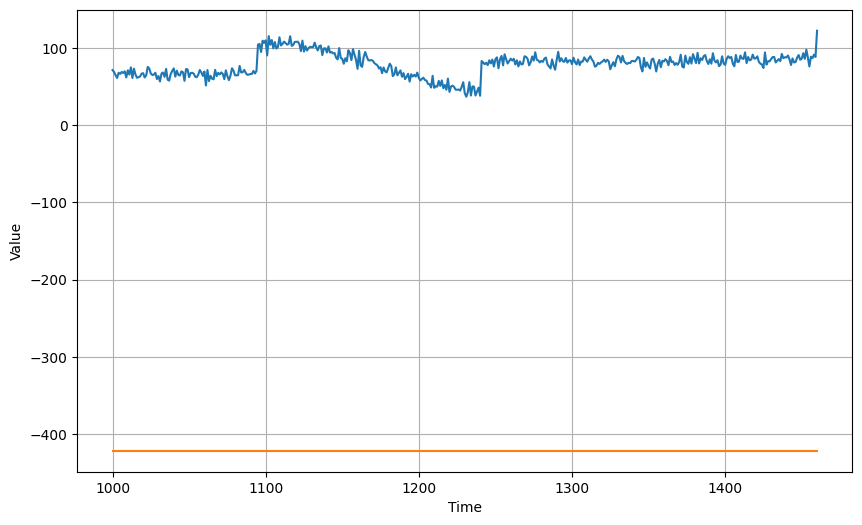

In [12]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, empirical_rnn_forecast)

In [13]:
keras.metrics.mean_absolute_error(x_valid, empirical_rnn_forecast).numpy()

499.85745

# Mechanized Stateful RNN

In [14]:
import sys
sys.path.append("..")

from mechanism.mechanized_sequential import MechanizedSequential
from mechanism.mechanized_sequential import Mechanism


In [37]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = sequential_window_dataset(x_train, window_size)

mechanized_model = MechanizedSequential([
  keras.layers.SimpleRNN(100, return_sequences=True, stateful=True,
                         batch_input_shape=[1, None, 1]),
  keras.layers.SimpleRNN(100, return_sequences=True, stateful=True),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200.0)
])
mechanized_model.choose_mech(Mechanism.GAUSSIAN)
mechanized_model.set_gaussian_para(0, 0.05)

lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 30))
reset_states = ResetStatesCallback()
optimizer = keras.optimizers.SGD(lr=1e-8, momentum=0.9)
mechanized_model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"],
              run_eagerly = True)

gaussian_history = mechanized_model.fit(train_set, epochs= 2,
                    callbacks=[lr_schedule, reset_states])

Epoch 1/2
In Gaussian Mechanism
Create noise when accessing the training data
      1/Unknown - 0s 310ms/step - loss: 402.8319 - mae: 403.3319In Gaussian Mechanism
Create noise when accessing the training data
      2/Unknown - 0s 105ms/step - loss: 402.0709 - mae: 402.5709In Gaussian Mechanism
Create noise when accessing the training data
      3/Unknown - 1s 104ms/step - loss: 391.2104 - mae: 391.7104In Gaussian Mechanism
Create noise when accessing the training data
      4/Unknown - 1s 104ms/step - loss: 343.8954 - mae: 344.3929In Gaussian Mechanism
Create noise when accessing the training data
      5/Unknown - 1s 105ms/step - loss: 321.5390 - mae: 322.0370In Gaussian Mechanism
Create noise when accessing the training data
      6/Unknown - 1s 106ms/step - loss: 332.4805 - mae: 332.9788In Gaussian Mechanism
Create noise when accessing the training data
      7/Unknown - 1s 111ms/step - loss: 339.6363 - mae: 340.1348In Gaussian Mechanism
Create noise when accessing the training dat

## Choose Threshold Mechanism and fit the model

In [40]:
import tensorflow_probability as tfp

class MechanizedSequential(tf.keras.Sequential):


  def __init__(self, *args, **kwargs):
      super(MechanizedSequential, self).__init__(*args, **kwargs)
      self.mechanism = None


      '''
      Parameters for the GnC mechanism 
      '''
      self.mu = 0.0
      self.sigma = 0.03

      '''
      Parameters for the GnC mechanism 
      '''      
      self.beta = None
      self.tau = None
      self.check_for_width = None   


      '''
      Parameters for the Naive Data Splitting mechanism 
      '''
      self.split_size = None


      '''
      Parameters for the Thresholdout mechanism 
      '''
      self.hold_size = None
      self.train_size = None
      self.hold_frac = None
      self.threshold = None
      self.noisy_thresh = None
         
  def choose_mech(self, mech = None):
     self.mechanism = mech
  
  def set_gaussian_para(self, mu, sigma):
     self.set_mechanism_para(mu, sigma)

  def set_mechanism_para(self, mu = 0.0, sigma = None, hold_frac = 0.5, threshold = 0.5, beta = None, tau = None, check_for_width = None):
      self.mu = mu
      self.sigma = sigma
      self.beta = beta
      self.tau = tau
      self.check_for_width = check_for_width
      assert 0.0 < hold_frac <= 1.0, "hold_frac should take a value in (0, 1]."
      self.hold_frac = hold_frac
      self.threshold = threshold
      self.noisy_thresh = self.threshold + np.random.laplace(0, 2 * self.sigma)
     
  def compute_metrics_gaussin(self, x, y, y_pred, sample_weight):
      x_noise = tf.random.normal(
            tf.shape(x),
            mean=self.mu,
            stddev=self.sigma,
            dtype=x.dtype,
            seed=None,
            name=None
            )
      
      noised_x = x_noise + x
  
      y_noise = tf.random.normal(
        tf.shape(y),
        mean=self.mu,
        stddev=self.sigma,
        dtype = y.dtype,
        seed=None,
        name=None
        )
      noised_y = y + y_noise

      self.compiled_metrics.update_state(noised_y, y_pred, sample_weight)

      metrics_results = super(MechanizedSequential, self).compute_metrics(
        noised_x, y, y_pred, sample_weight)
      return metrics_results
  
  def compute_metrics(self, x, y, y_pred, sample_weight):
      if self.mechanism is None:
        self.compiled_metrics.update_state(y, y_pred, sample_weight)
        return super(MechanizedSequential, self).compute_metrics(
        x, y, y_pred, sample_weight)
      elif self.mechanism == Mechanism.GAUSSIAN:
         print("In Gaussian Mechanism")
         return self.compute_metrics_gaussin(x, y, y_pred, sample_weight)
      else:
         self.compiled_metrics.update_state(y, y_pred, sample_weight)
         return super(MechanizedSequential, self).compute_metrics(
        x, y, y_pred, sample_weight)
      
  def train_step(self, data):
      # Unpack the data. Its structure depends on your model and
      # on what you pass to `fit()`.
      if self.mechanism is None:
        return super(MechanizedSequential, self).train_step(data)
      elif self.mechanism == Mechanism.GAUSSIAN:
         print("In Gaussian Mechanism")
         return self.gaussian_train_step(data)
      elif self.mechanism == Mechanism.DATASPLIT:
         print("In Naive Data Splitting Mechanism")
         return self.data_split_train_step(data)
      elif self.mechanism == Mechanism.THRESHOLD:
         print("In Threshold out Mechanism")
         return self.thresholdout_train_step(data)
      else:
        return super(MechanizedSequential, self).train_step(data)

      
  
  def gaussian_train_step(self, data):
      # Unpack the data. Its structure depends on your model and
      # on what you pass to `fit()`.
      x, y = data
      with tf.GradientTape() as tape:
         print("Create noise when accessing the training data")
         x_noise = tf.random.normal(
               tf.shape(x),
               mean=self.mu,
               stddev=self.sigma,
               dtype=x.dtype,
               seed=None,
               name=None
               )
         noised_x = x_noise + x
         y_pred = self(noised_x, training=True)  # Forward pass
         # Compute the loss value
         # (the loss function is configured in `compile()`)
         noise = tf.random.normal(
               tf.shape(y_pred),
               mean=self.mu,
               stddev=self.sigma,
               dtype = y_pred.dtype,
               seed=None,
               name=None
               )
         
         loss = self.compiled_loss(y, y_pred, regularization_losses=self.losses)

      # Compute gradients
      trainable_vars = self.trainable_variables
      gradients = tape.gradient(loss, trainable_vars)

      # Update weights
      self.optimizer.apply_gradients(zip(gradients, trainable_vars))

      # Update metrics (includes the metric that tracks the loss)
      self.compiled_metrics.update_state(y, y_pred)

      # Return a dict mapping metric names to current value
      return {m.name: m.result() for m in self.metrics}
  
  '''
  Naive Data Splitting Mechanism:
  Either splitting the data in smaller batch-size and train with more steps,
  or doing the same training steps as the one without any mechanism.
  This one is the version that is the same as the train_step without any mechanism.
  '''
  def data_split_train_step(self, data):
      # Unpack the data. Its structure depends on your model and
      # on what you pass to `fit()`.

      x, y = data
      with tf.GradientTape() as tape:
         print("In Naive Data Split")
         y_pred = self(x, training=True)  # Forward pass
         loss = self.compiled_loss(y, y_pred, regularization_losses=self.losses)
      # Compute gradients
      trainable_vars = self.trainable_variables
      gradients = tape.gradient(loss, trainable_vars)

      # Update weights
      self.optimizer.apply_gradients(zip(gradients, trainable_vars))

      # Update metrics (includes the metric that tracks the loss)
      self.compiled_metrics.update_state(y, y_pred)

      # Return a dict mapping metric names to current value
      return {m.name: m.result() for m in self.metrics}
  
  def thresholdout_train_step(self, data):
      # Unpack the data. Its structure depends on your model and
      # on what you pass to `fit()`.
      x, y = data
      if(x.shape[0] > 1):
         hold_size, train_size = int(x.shape[0]  * (self.hold_frac)), int(x.shape[0]  * (1.0 - self.hold_frac))
         x_train, y_train, x_hold, y_hold = x[hold_size:], y[hold_size:], x[:hold_size], y[:hold_size]
      else:
         hold_size, train_size = x.shape[0], x.shape[0]
         x_train, y_train, x_hold, y_hold = x, y, x, y
         
      with tf.GradientTape() as tape:

         y_pred_train = self(x_train, training=True)  # Forward pass
         y_pred_hold = self(x_hold, training = True)
         '''
         TODO: Need to consider one of the following model as one shot of query:
          model-1. one step of training, the result of the logistic is a query
          model-2. one step of training, the losse of the trained logistic v.s. the true logistic.
         '''

         '''
         model-1.
         drawback: the query result isn't unform data type, the trained logistic has different size dependents on the databse size.
         '''
         #TODO: subtraction between the tensors of different size
         abs_diff = abs(np.sum(y_pred_train, axis = 0) / train_size - np.sum(y_pred_hold, axis = 0) / hold_size)
         mean_abs_diff = sum(abs_diff) / y.shape[1]
         print(mean_abs_diff)
         if mean_abs_diff >= self.noisy_thresh + np.random.laplace(0, 4 * self.sigma):
            self.noisy_thresh = self.threshold + np.random.laplace(0, 2 * self.sigma)
            y_true, y_pred = y_hold, y_pred_hold + tfp.distributions.Laplace(self.mu, self.sigma).sample(tf.shape(y_pred_hold))
            loss = self.compiled_loss(y_hold, y_pred_hold, regularization_losses=self.losses)
         else:
            y_true, y_pred = y_train, y_pred_train
            loss = self.compiled_loss(y_train, y_pred_train, regularization_losses=self.losses)

         '''
         model-2:
         drawback: the "loss of  the trained logistic v.s. the true logistic" isn't a direct
          query on the data. 
         advantage: the losses in different steps or different size of database always have the same type.
         '''
         loss = self.compiled_loss(y_train, y_pred_train, regularization_losses=self.losses)
         loss_hold = self.compiled_loss(y_hold, y_pred_hold, regularization_losses=self.losses)

         if np.abs(loss - loss_hold) >= self.noisy_thresh + np.random.laplace(0, 4 * self.sigma):
            self.noisy_thresh = self.threshold + np.random.laplace(0, 2 * self.sigma)

            loss = loss_hold + tfp.distributions.Laplace(self.mu, self.sigma).sample(tf.shape(loss_hold))
            # min(1.0, max(0.0, loss_hold + np.random.laplace(0, self.sigma)))
            y_true, y_pred = y_hold, y_pred_hold
         else:
            y_true, y_pred = y_train, y_pred_train
            loss = self.compiled_loss(y_train, y_pred_train, regularization_losses=self.losses)

      
      
      # Compute gradients
      trainable_vars = self.trainable_variables
      gradients = tape.gradient(loss, trainable_vars)
      # Update weights
      self.optimizer.apply_gradients(zip(gradients, trainable_vars))

      # Update metrics (includes the metric that tracks the loss)
      self.compiled_metrics.update_state(y_true, y_pred)

      # Return a dict mapping metric names to current value
      return {m.name: m.result() for m in self.metrics}

In [41]:
window_size = 30
train_set = sequential_window_dataset(x_train, window_size)

mechanized_model = MechanizedSequential([
  keras.layers.SimpleRNN(100, return_sequences=True, stateful=True,
                         batch_input_shape=[1, None, 1]),
  keras.layers.SimpleRNN(100, return_sequences=True, stateful=True),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200.0)
])

mechanized_model.choose_mech(Mechanism.THRESHOLD)
mechanized_model.set_mechanism_para(sigma = 0.1, hold_frac = 0.4, threshold = 0.5)


lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 30))
reset_states = ResetStatesCallback()
optimizer = keras.optimizers.SGD(lr=1e-8, momentum=0.9)
mechanized_model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"],
              run_eagerly = True)
threshold_history = mechanized_model.fit(train_set, epochs= 2,
                    callbacks=[lr_schedule, reset_states])

Epoch 1/2
In Threshold out Mechanism
[5.910347]
      1/Unknown - 0s 254ms/step - loss: 54.3647 - mae: 53.3533In Threshold out Mechanism
[0.49110916]
      2/Unknown - 0s 160ms/step - loss: 46.2306 - mae: 45.9420In Threshold out Mechanism
[2.0589159]
      3/Unknown - 1s 167ms/step - loss: 36.8488 - mae: 36.9076In Threshold out Mechanism
[7.799161]
      4/Unknown - 1s 180ms/step - loss: 45.0041 - mae: 45.6075In Threshold out Mechanism
[15.069088]
      5/Unknown - 1s 195ms/step - loss: 50.1596 - mae: 51.2252In Threshold out Mechanism
[4.440402]
      6/Unknown - 1s 193ms/step - loss: 45.4714 - mae: 46.2989In Threshold out Mechanism
[0.4676835]
      7/Unknown - 1s 193ms/step - loss: 41.7436 - mae: 42.5358In Threshold out Mechanism
[1.3205292]
      8/Unknown - 2s 189ms/step - loss: 38.0333 - mae: 39.5951In Threshold out Mechanism
[0.9134107]
      9/Unknown - 2s 187ms/step - loss: 35.3167 - mae: 37.2809In Threshold out Mechanism
[0.64440906]
     10/Unknown - 2s 185ms/step - loss: 33.

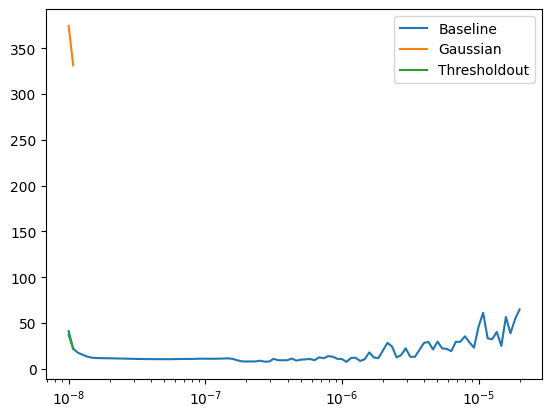

In [42]:
plt.semilogx(history.history["lr"], history.history["loss"], label = "Baseline")
plt.semilogx(gaussian_history.history["lr"], gaussian_history.history["loss"], label = "Gaussian")
plt.semilogx(threshold_history.history["lr"], threshold_history.history["loss"], label = "Thresholdout")
plt.legend()
plt.show()


## Mechanized model with check point

In [48]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = sequential_window_dataset(x_train, window_size)
valid_set = sequential_window_dataset(x_valid, window_size)

mechanized_model = MechanizedSequential([
  keras.layers.SimpleRNN(100, return_sequences=True, stateful=True,
                         batch_input_shape=[1, None, 1]),
  keras.layers.SimpleRNN(100, return_sequences=True, stateful=True),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200.0)
])

mechanized_model.choose_mech(Mechanism.GAUSSIAN)
mechanized_model.set_gaussian_para(0, 0.05)

optimizer = keras.optimizers.SGD(lr=1e-7, momentum=0.9)
mechanized_model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"], 
              run_eagerly = True)
reset_states = ResetStatesCallback()
mechanized_model_checkpoint = keras.callbacks.ModelCheckpoint(
    "mechanized_model_checkpoint.h5", save_best_only=True)
early_stopping = keras.callbacks.EarlyStopping(patience=50)

mechanized_model.fit(train_set, epochs = 10,
          validation_data=valid_set,
          callbacks=[early_stopping, mechanized_model_checkpoint, reset_states])

Epoch 1/10
In Gaussian Mechanism
Create noise when accessing the training data
      1/Unknown - 0s 178ms/step - loss: 6.2365 - mae: 6.7154In Gaussian Mechanism
Create noise when accessing the training data
      2/Unknown - 0s 102ms/step - loss: 1635.3549 - mae: 1635.8442In Gaussian Mechanism
Create noise when accessing the training data
      3/Unknown - 0s 99ms/step - loss: 5669.0332 - mae: 5669.5259 In Gaussian Mechanism
Create noise when accessing the training data
      4/Unknown - 0s 99ms/step - loss: 9715.6592 - mae: 9716.1543In Gaussian Mechanism
Create noise when accessing the training data
      5/Unknown - 1s 100ms/step - loss: 11305.3408 - mae: 11305.8369In Gaussian Mechanism
Create noise when accessing the training data
      6/Unknown - 1s 102ms/step - loss: 11344.9209 - mae: 11345.4180In Gaussian Mechanism
Create noise when accessing the training data
      7/Unknown - 1s 104ms/step - loss: 13502.1074 - mae: 13502.6045In Gaussian Mechanism
Create noise when accessing th

In [49]:
gaussian_model = keras.models.load_model("mechanized_model_checkpoint.h5",
                                         custom_objects={'MechanizedSequential':MechanizedSequential})

In [50]:
gaussian_model.reset_states()
gaussian_rnn_forecast = gaussian_model.predict(series[np.newaxis, :, np.newaxis])
gaussian_rnn_forecast = gaussian_rnn_forecast[0, split_time - 1:-1, 0]

1/1 [==============================] - 0s 260ms/step


## Choose Threshold mechanism

In [51]:
mechanized_model.choose_mech(Mechanism.THRESHOLD)
mechanized_model.set_mechanism_para(sigma = 0.1, hold_frac = 0.4, threshold = 0.5)


In [52]:
optimizer = keras.optimizers.SGD(lr=1e-7, momentum=0.9)
mechanized_model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"], 
              run_eagerly = True)
reset_states = ResetStatesCallback()
mechanized_model_checkpoint = keras.callbacks.ModelCheckpoint(
    "mechanized_model_checkpoint.h5", save_best_only=True)
early_stopping = keras.callbacks.EarlyStopping(patience=50)

mechanized_model.fit(train_set, epochs = 10,
          validation_data=valid_set,
          callbacks=[early_stopping, mechanized_model_checkpoint, reset_states])

Epoch 1/10
In Threshold out Mechanism
[16.194149]
      1/Unknown - 0s 251ms/step - loss: 6320.0454 - mae: 6325.9438In Threshold out Mechanism
[0.]
      2/Unknown - 0s 207ms/step - loss: 21946.0020 - mae: 19995.9590In Threshold out Mechanism
[3565.3845]
      3/Unknown - 1s 185ms/step - loss: 22482.2266 - mae: 21292.2246In Threshold out Mechanism
[1422.1628]
      4/Unknown - 1s 183ms/step - loss: 23194.4805 - mae: 22304.5449In Threshold out Mechanism
[1915.1641]
      5/Unknown - 1s 188ms/step - loss: 26393.3418 - mae: 25789.7891In Threshold out Mechanism
[0.]
      6/Unknown - 1s 183ms/step - loss: 21566.8047 - mae: 21868.3535In Threshold out Mechanism
[0.]
      7/Unknown - 1s 179ms/step - loss: 21096.9414 - mae: 21422.6074In Threshold out Mechanism
[0.]
      8/Unknown - 1s 177ms/step - loss: 18376.3203 - mae: 19001.4180In Threshold out Mechanism
[1527.4001]
      9/Unknown - 2s 177ms/step - loss: 18312.4844 - mae: 18890.5371In Threshold out Mechanism
[0.]
     10/Unknown - 2s 176

In [ ]:
threshold_model = keras.models.load_model("mechanized_model_checkpoint.h5",
                                         custom_objects={'MechanizedSequential':MechanizedSequential})
threshold_rnn_forecast = threshold_model.predict(series[np.newaxis, :, np.newaxis])
threshold_rnn_forecast = threshold_rnn_forecast[0, split_time - 1:-1, 0]

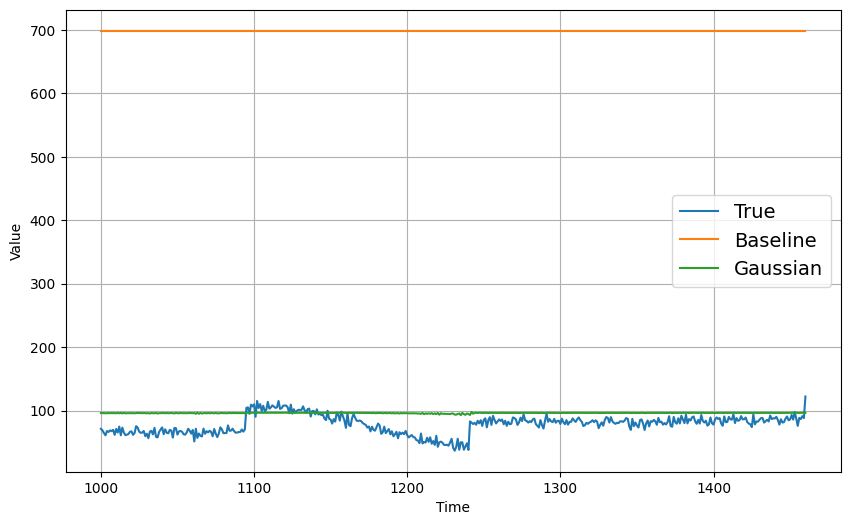

In [31]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid, label = "True")
plot_series(time_valid, empirical_rnn_forecast, label = "Baseline")
plot_series(time_valid, gaussian_rnn_forecast, label = "Gaussian")
plot_series(time_valid, threshold_rnn_forecast, label = "Thresholdout")

In [32]:
keras.metrics.mean_absolute_error(x_valid, empirical_rnn_forecast).numpy()

620.14453

In [33]:
keras.metrics.mean_absolute_error(x_valid, gaussian_rnn_forecast).numpy()

19.403278

In [ ]:
keras.metrics.mean_absolute_error(x_valid, threshold_rnn_forecast).numpy()